![jolie image](img/download.jpg)
# Livrable 3
## Captioning

## Groupe de projet 1 :
- Rémi Papin
- Fabien Richard
- Zacharia Azzouzi

## Introduction

Dans ce troisième livrable nous allons réaliser du Captioning, c'est-à-dire la génération automatique des légendes. Nous utiliserons deux techniques avancées de Machine Learning :
- les réseaux de neurones récurrents (RNN);
- les réseaux de neurones convolutifs (CNN).

Les RNN permettent de générer les étiquettes, il sera nécessaire de passer avant par des CNN pour extraire des features. Ces features sont ensuite passées dans un système d'attention qui va permettre de faciliter le système de captioning.

Ici nous utilisons le modèle déja entrainé InceptionV3. Ainsi nous n'avons pas besoin d'entrainer notre propre modèle d'extraction de features et gagner de précieuses minutes.

Nous nous appuierons sur des datasets d'étiquetage classiques pour effectuer l'apprentissage supervisé du système de captioning.

De plus nous fusionnons les livrable 1 (classification binaire), 2(autoencodeur / prétraitement de l'image) et 3 (captioning) de façon à obtenir un pipeline automatisé.

## Imports

In [1]:
# Imports de bases
import os
import time
import json
import cv2
import pickle
import collections
import random
import re

#Fichier de configuration Path datasets
import configuration

#Classes Python modèle L1 et L2
import ClassificationBinaire
import Denoising

# Imports spécialisés
import numpy as np
from glob import glob
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


## Configuration

Determination des chemins de dataset et des tailles d'images

In [2]:
data_dir = configuration.data_dir
image_to_test_dir = configuration.image_to_test_dir
image_h = 304
image_w = 304

image_h_classification = 180
image_w_classification = 180

class_names = ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']

## Classification

Chargement du modèle de classification pour determiner si l'image est une photo ou non

In [3]:
binary_classifier = ClassificationBinaire.ClassificationBinaire(image_h_classification, image_w_classification, 2)
binary_classifier.load_model()
binary_classifier.summary_model()

Found 5757 files belonging to 4 classes.
Using 4606 files for training.
Found 5757 files belonging to 4 classes.
Using 1151 files for validation.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                        

## Debruitage


In [4]:
denoiser = Denoising.Denoising()
denoiser.build_autoencoder(image_h, image_w, 3, filters=(16, 32))
denoiser.load_model()
denoiser.summary_model()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 304, 304, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 304, 304, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 152, 152, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 152, 152, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 76, 76, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 76, 76, 32)        

## Captioning

Liste des paramètres nécessaires pour l'execution du captioning

In [5]:
# Pre-traitement numpy avant de passer les data dans Inception
pre_traitement = False
# Chosir les 5000 mots les plus frequents du vocabulaire
top_k = 5000
# Répartition des dataset (entre 0 et 1)
pct_train_dataset = 0.8
# Taille du batch
BATCH_SIZE = 32
# Taille du buffer pour melanger les donnes
BUFFER_SIZE = 1000
# Taille de la couche d'extraction de features
embedding_dim = 256
# Taille de la couche caché dans le RNN
units = 512

#Path pour le dossier de checkpoint
checkpoint_path = "./checkpoints/train"
#Nombre d'epochs
EPOCHS = 25
#Besoin d'entainer le modèle
is_train_needed = False

<b>Chargement des données</b>

Création des tableaux contenant les données et les labels

In [6]:
# Chemin du fichier d'annotations
annotation_folder = data_dir + "/annotations/"
annotation_file = data_dir +"/annotations/captions_train2014.json"

# Chemin du dossier contenant les images à annoter
image_folder = data_dir + '/train2014/'
PATH = image_folder

# Lecture du fichier d'annotation
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Grouper toutes les annotations ayant le meme identifiant.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    # marquer le debut et la fin de chaque annotation
    caption = "<start> " + val['caption'] + ' <end>'
    # L'identifiant d'une image fait partie de son chemin d'accès
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    # Rajout du caption associé à image_path
    image_path_to_caption[image_path].append(caption)
    
# Prendre les premières images seulement
# image_paths = list(image_path_to_caption.keys())
# train_image_paths = image_paths[:2000]
image_paths = [PATH + filename for filename in os.listdir(PATH) if filename.endswith('.jpg')]
train_image_paths = image_paths[:7000]
print(len(train_image_paths))




5342


On retrouve le nombre d'images utilisés pour l'entrainement de notre modèle

In [7]:
# Liste de toutes les annotations
train_captions = []
# Liste de tous les noms de fichiers des images dupliquées (en nombre d'annotations par image)
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    # Rajout de caption_list dans train_captions
    train_captions.extend(caption_list)
    # Rajout de image_path dupliquée len(caption_list) fois
    img_name_vector.extend([image_path] * len(caption_list))

Ici on associe à chaque annotation l'image correspondante.

### Transfert Learning

On vient récuperer le modèle Inception V3 déjà entrainé

In [8]:
# Telechargement du modèle InceptionV3 pré-entrainé avec la cassification sur ImageNet
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
# Creation d'une variable qui sera l'entrée du nouveau modèle de pre-traitement d'images
new_input = image_model.input
# récupérer la dernière couche caché qui contient l'image en representation compacte
hidden_layer = image_model.layers[-1].output

# Modèle qui calcule une representation dense des images avec InceptionV3
image_features_extract_model =  tf.keras.Model(new_input, hidden_layer)

# Définition de la fonction load_image
def load_image(image_path):
    """
    La fonction load_image a pour entrée le chemin d'une image et pour sortie un couple
    contenant l'image traitée ainsi que son chemin d'accès.
    La fonction load_image effectue les traitement suivant:
        1. Chargement du fichier correspondant au chemin d'accès image_path
        2. Décodage de l'image en RGB.
        3. Redimensionnement de l'image en taille (299, 299).
        4. Normalisation des pîxels de l'image entre -1 et 1
    """
    img =  tf.io.read_file(image_path)
    img =  tf.image.decode_jpeg(img, channels=3)
    img =  tf.image.resize(img, (299, 299))
    img =  tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

# Pré-traitement des images
# Prendre les noms des images
encode_train = sorted(set(img_name_vector))

# Creation d'une instance de "tf.data.Dataset" partant des noms des images 
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# Division du données en batchs après application du pré-traitement fait par load_image
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)




### Pré-traitement
On prépare l'ensemble du dataset pour qu'il soi compatible avec le model Inception V3.

In [9]:
# # Parcourir le dataset batch par batch pour effectuez le pré-traitement d'InceptionV3
if pre_traitement :
    for img, path in tqdm(image_dataset):
        # Pré-traitement du batch (de taille (16,8,8,2048)) courant par InceptionV3
        batch_features = image_features_extract_model(img)
        # Resize du batch de taille (16,8,8,2048) en taille (16,64,2048)
        batch_features = tf.reshape(batch_features,
                                  (batch_features.shape[0], -1, batch_features.shape[3]))
        # Parcourir le batch courant et stocker le chemin ainsi que le batch avec np.save()
        for bf, p in zip(batch_features, path):
            path_of_feature = p.numpy().decode("utf-8")

            np.save(path_of_feature, bf.numpy())

**Pré-traitement des annotations**

On associe chaque caractère avec un token (chiffre). En effet, l'entrainement du modèle s'effectue grace à des opérations mathématiques donc il faut que chaque lettre soit représentées par un chiffre.

In [10]:
# Trouver la taille maximale 
def calc_max_length(tensor):
    return max(len(t) for t in tensor)


#La classe Tokenizer permet de faire du pre-traitement de texte pour reseau de neurones 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
# Construit un vocabulaire en se basant sur la liste train_captions
tokenizer.fit_on_texts(train_captions)

# Créer le token qui sert à remplir les annotations pour egaliser leurs longueur
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Creation des vecteurs(liste de token entiers) à partir des annotations (liste de mots)
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Remplir chaque vecteur à jusqu'à la longueur maximale des annotations
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calcule la longueur maximale qui est utilisée pour stocker les poids d'attention 
# Elle servira plus tard pour l'affichage lors de l'évaluation
max_length = calc_max_length(train_seqs)

In [11]:
tokenizer.index_word[10]

'and'

On remarque que le dixième mot le plus présent dans les annotations est le mot 'and'

# Formation du jeu d'entrainement et de test :
On doit associer chaque image avec le fichier correspond issue du pré-traitement.
Ensuite on scinde le dataset en jeu d'entrainement et jeu de validation.

In [12]:
img_to_cap_vector = collections.defaultdict(list)
# Creation d'un dictionnaire associant les chemins des images avec (fichier .npy) aux annotationss
# Les images sont dupliquées car il y a plusieurs annotations par image

for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

"""
Création des datasets de formation et de validation en utilisant 
un fractionnement 80-20 de manière aléatoire
""" 
# Prendre les clés (noms des fichiers d'images traites), *celles-ci ne seront pas dupliquées*
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)
# Diviser des indices en entrainement et test
slice_index = int(len(img_keys)* pct_train_dataset)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]
print('Nombre d\'images : ' + str(len(img_name_vector)))
print('Nombre d\'annotations : ' + str(len(cap_vector)))

Nombre d'images : 26721
Nombre d'annotations : 26721


On retrouve 10001 image et annotation dans notre dataset

Chaque image possede plusieurs annotations. Ainsi, il est nécessaire de créer une liste contenant à chaque fois une correspondance image => annotation.
Une fois cette association créée, on peut séparer le jeu de validation et le jeu d'entrainement.

In [13]:
"""
Les jeux d'entrainement et de tests sont sous forme
de listes contenants les mappings :(image prétraitée ---> jeton d'annotation(mot) )
"""

# Boucle pour construire le jeu d'entrainement
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    # Duplication des images en le nombre d'annotations par image
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

# Boucle pour construire le jeu de test
img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    # Duplication des images en le nombre d'annotations par image
    img_name_val.extend([imgv] * capt_len)
    cap_val.extend(img_to_cap_vector[imgv])

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(21372, 21372, 5345, 5349)

On retrouve bien 80% du dataset pour l'entrainement et 20% pour la validation.

### Création du dictionnaire de vocabulaire

On restreint le nombre de mots enregistrés dans le vocabulaire pour limiter la taille de la dernière couche du modèle de captioning afin d'améliorer les performances.

In [14]:

vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

# La forme du vecteur extrait à partir d'InceptionV3 est (64, 2048)
# Les deux variables suivantes representent la forme de ce vecteur
features_shape = 2048
attention_features_shape = 64

# Fonction qui charge les fichiers numpy des images prétraitées
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

# Creation d'un dataset de "Tensor"s (sert à representer de grands dataset)
# Le dataset est cree a partir de "img_name_train" et "cap_train"
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# L'utilisation de map permet de charger les fichiers numpy (possiblement en parallèle)
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Melanger les donnees et les diviser en batchs
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Le modèle :

**L'encodeur CNN :**

L'encodeur CNN génère une représentation suffisante de l'image et la transmet au décodeur RNN pour l'étiqueter. Le CNN prend en entrée les caractéristiques de l'image qui ont été prétraitées par InceptionV3 et stockées sur disque. 

En remarque, dans la partie CNN de ce réseau de neurones, la dernière couche convolutive n'est pas aplatie. N'oubliez pas que le format d'image produit par le prétraitement InceptionV3 est 8x8x2048. Ces images ont été redimensionnées à 64x2048. Cela signifie que pour chacun des 64 emplacements de l'image prétraitée, la représentation contient 2048 caractéristiques extraites par InceptionV3. Par conséquent, l'entrée du décodeur CNN est un lot où chaque élément se compose de 2048 caractéristiques à 64 positions (initialement 8x8) de l'image prétraitée.

L’avantage de cette représentation par rapport à la représentation aplatie est de préserver de l’information spatiale au niveau des couches du réseau de neurones. Ceci permettra au mécanisme d’attention de la partie RNN de détecter les positions intéressantes au niveau de l’image et de renseigner l’algorithme sur les zones où il devra porter le plus d’importance pour légender l’image.

In [15]:
class CNN_Encoder(tf.keras.Model):
    # Comme les images sont déjà prétraitées par InceptionV3 est représentées sous forme compacte
    # L'encodeur CNN ne fera que transmettre ces caractéristiques à une couche dense
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # forme après fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

**Le mécanisme d'attention :**

Le mécanisme d'attention ressemble beaucoup à un RNN classique, à quelques différences près. La partie attention prend en entrée la représentation de l'image prétraitée renvoyée par le CNN et la valeur courante de l'état caché du GRU, et prend en sortie un vecteur de contexte reflétant les caractéristiques les plus importantes de l'image. 

Une étape intermédiaire dans le calcul de ce vecteur consiste à calculer des poids d'attention qui représentent l'importance de chaque position de l'image (sur 64 au total) dans sa prédiction d'annotation. Globalement, on peut dire que le vecteur d'attention dépend des scores tirés des représentations spatiales et textuelles des images. Ce vecteur d'attention renvoie la pertinence de chaque emplacement et est utilisé pour calculer le vecteur de contexte, qui nous donnera l'importance des caractéristiques de l'image.


In [16]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) forme == (batch_size, 64, embedding_dim)

        # forme de la couche cachée == (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        attention_hidden_layer = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # Cela vous donne un score non normalisé pour chaque caractéristique de l'image.
        score = self.V(attention_hidden_layer)

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

**Le décodeur RNN :**

Le rôle du décodeur RNN est d'utiliser la représentation prétraitée de l'image pour prédire mot à mot sa légende. Ce RNN a une seule cellule de type GRU. Le GRU a un état caché, qui représente la mémoire du dernier élément qu'il a vu. Le GRU met à jour son état avant de retourner, et pour cela il utilise des mécanismes de mémoire très sophistiqués.

Le décodeur est structuré comme suit, à chaque appel du RNN, le mot courant ainsi que la représentation de l'image et l'état caché du GRU sont utilisés en entrée du RNN. Puisque les mots sont représentés par des entiers, ils doivent passer par une couche appelée couche d'intégration, qui se chargera de calculer une représentation vectorielle de taille output_dim à partir des nombres représentant les mots.

À côté de ça, le mécanisme d’attention fournit un vecteur représentant le contexte de l’image, un vecteur qui nous renseigne sur les caractéristiques principales de l’image. Ce vecteur est calculé par un appel du mécanisme d’attention en lui fournissant en entrée les caractéristiques de l’image encodée par le CNN ainsi que l’état caché du GRU qui résume l’historique des mots vues par le RNN.

Ensuite, le mot courant et le contexte sont concaténées pour former le vecteur d’entrée du GRU qui à son tour calcule l’état à l’étape suivante. Cet état est passé par une couche dense de taille units puis la sortie de cette couche est passée à une autre couche dense de taille vocab_size qui retourne le score associé à chaque mot du vocabulaire afin de prédire le mot suivant.

In [17]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        #Couche dense qui aura pour entrée la sortie du GRU
        self.fc1 = tf.keras.layers.Dense(units)

        # Dernière couche dense
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention =  BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # L'attention est defini par un modèle a part
        context_vector, attention_weights = self.attention(features, hidden)
        # Passage du mot courant à la couche embedding
        x = self.embedding(x)
#A COMPLETER
        # Concaténation
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # Passage du vecteur concaténé à la gru
        output, state = self.gru(x)
        
        # Couche dense
        y = self.fc1(output)

        y = tf.reshape(y, (-1, x.shape[2]))
        
        # Couche dense
        y = self.fc2(y)
        
        return y, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

**Combiner la partie encodeur et décodeur :**


In [18]:
# Création de l'encodeur
encoder = CNN_Encoder(embedding_dim)
# Création du décodeur
decoder = RNN_Decoder(embedding_dim, units, vocab_size)


In [ ]:
# Optimiseur ADAM
optimizer = tf.keras.optimizers.Adam()

# La fonction de perte
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### Fonction de loss

On choisit la fonction de SparseCategoricalCrossentropy lorsqu'il y a deux classes d'étiquettes ou plus. Les étiquettes doivent être fournies sous forme d'entiers.
Celle ci permet de calculer l'entropie croisée entre les labels et la prédiction.
La fonction de perte est une valeur relative, elle permet de suivre l'évolution de l'entrainement de notre modèle.

### Fonction d'optimisation

On choisit la fonction d'optimisation Adam car celle qui permet les meilleurs résultats pour des modèles de classification.

L'optimisation d'Adam est une méthode de descente de gradient stochastique qui est basée sur l'estimation adaptative des moments de premier ordre et de second ordre.

La méthode est efficace sur le plan informatique, peu exigeante en mémoire, invariante à la remise à l'échelle diagonale des gradients, et bien adaptée aux problèmes qui sont grands en termes de données/paramètres.

#### Création de checkpoints

In [20]:

ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

On utilise le checkpoint manager fourni par Tensorflow.
Il permet de gerer le nombre de checkpoint a garder.
De plus, il gère l'historique des checkpoints créé avec une nomenclature et un timestamp enregistré dans le fichier "checkpoint"
Ainsi on peux reprendre un entrainement à partir d'une certaine epoch en chargeant le dernier checkpoint généré.

In [21]:
start_epoch = 0
print(ckpt_manager.directory)
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    print(start_epoch)
    # Restaurer le dernier checkpoint dans checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

./checkpoints/train
25


## Entrainement


In [22]:
loss_plot = []
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # Initialisation de l'état caché pour chaque batch
    hidden = decoder.reset_state(batch_size=target.shape[0])
    
    # Initialiser l'entrée du décodeur
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: # Offre la possibilité de calculer le gradient du loss
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # Prédiction des i'èmes mot du batch avec le décodeur
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            # Le mot correct à l'étap i est donné en entrée à l'étape (i+1)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

Le code global contenant la boucle d'entrainement est présenté ci-dessous. Cette boucle parcours le jeu de données d'entrainement batch par batch et entraine le réseaux avec ceux-ci.
A la fin de chaque epoch, la loss et l'accuracy sont calculées. Grace à ces données, on peut observer l'évolution de l'entrainement au fil du temps.

In [23]:
if is_train_needed :
    for epoch in range(start_epoch, EPOCHS):
        start = time.time()
        total_loss = 0

        for (batch, (img_tensor, target)) in enumerate(dataset):
            batch_loss, t_loss = train_step(img_tensor, target)
            total_loss += t_loss

            if batch % 50 == 0:
                print ('Epoch {} Batch {} Loss {:.4f}'.format(
                  epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
        # sauvegarde de la perte
        loss_plot.append(total_loss / num_steps)
        print('modulo epoch ' + str(epoch) + ' = ' + str(epoch % 3))
        if epoch % 1 == 0:
            print('saving checkpoint at epoch ' + str(epoch))
            ckpt_manager.save()

        print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                             total_loss/num_steps))
        print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


    # Affichage de la courbe d'entrainement
    plt.plot(loss_plot)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Plot')
    plt.show()

Voici la courbe d'évolution de la fonction de "loss" :
![Courbe loss](img/Loss-25epochs-7000pic.png)

Enfin, la sortie du suivi de l'entrainement :
```bash
Epoch 1 Batch 0 Loss 2.0037
Epoch 1 Batch 50 Loss 1.2357
Epoch 1 Batch 100 Loss 1.1284
Epoch 1 Batch 150 Loss 0.9876
Epoch 1 Batch 200 Loss 1.0282
Epoch 1 Batch 250 Loss 0.9860
Epoch 1 Batch 300 Loss 0.9383
Epoch 1 Batch 350 Loss 0.9219
Epoch 1 Batch 400 Loss 0.9301
Epoch 1 Batch 450 Loss 0.8943
Epoch 1 Batch 500 Loss 0.8431
Epoch 1 Batch 550 Loss 0.8363
Epoch 1 Batch 600 Loss 0.8035
Epoch 1 Batch 650 Loss 0.6877
modulo epoch 0 = 0
saving checkpoint at epoch 0
Epoch 1 Loss 0.972917
Time taken for 1 epoch 162.08737564086914 sec

Epoch 2 Batch 0 Loss 0.8887
Epoch 2 Batch 50 Loss 0.6514
Epoch 2 Batch 100 Loss 0.8166
Epoch 2 Batch 150 Loss 0.7264
Epoch 2 Batch 200 Loss 0.7949
Epoch 2 Batch 250 Loss 0.8197
Epoch 2 Batch 300 Loss 0.8920
Epoch 2 Batch 350 Loss 0.7513
Epoch 2 Batch 400 Loss 0.6819
Epoch 2 Batch 450 Loss 0.6670
Epoch 2 Batch 500 Loss 0.7374
Epoch 2 Batch 550 Loss 0.7505
Epoch 2 Batch 600 Loss 0.8997
Epoch 2 Batch 650 Loss 0.6524
modulo epoch 1 = 1
saving checkpoint at epoch 1
Epoch 2 Loss 0.755612
Time taken for 1 epoch 76.86665034294128 sec

Epoch 3 Batch 0 Loss 0.7750
Epoch 3 Batch 50 Loss 0.7706
Epoch 3 Batch 100 Loss 0.6913
Epoch 3 Batch 150 Loss 0.7272
Epoch 3 Batch 200 Loss 0.7058
Epoch 3 Batch 250 Loss 0.6501
Epoch 3 Batch 300 Loss 0.6384
Epoch 3 Batch 350 Loss 0.6570
Epoch 3 Batch 400 Loss 0.6952
Epoch 3 Batch 450 Loss 0.5954
Epoch 3 Batch 500 Loss 0.6685
Epoch 3 Batch 550 Loss 0.5716
Epoch 3 Batch 600 Loss 0.6314
Epoch 3 Batch 650 Loss 0.6109
modulo epoch 2 = 2
saving checkpoint at epoch 2
Epoch 3 Loss 0.682131
Time taken for 1 epoch 75.92325806617737 sec

Epoch 4 Batch 0 Loss 0.6413
Epoch 4 Batch 50 Loss 0.5904
Epoch 4 Batch 100 Loss 0.6695
Epoch 4 Batch 150 Loss 0.6565
Epoch 4 Batch 200 Loss 0.6738
Epoch 4 Batch 250 Loss 0.5761
Epoch 4 Batch 300 Loss 0.6920
Epoch 4 Batch 350 Loss 0.6049
Epoch 4 Batch 400 Loss 0.5898
Epoch 4 Batch 450 Loss 0.5713
Epoch 4 Batch 500 Loss 0.5875
Epoch 4 Batch 550 Loss 0.5755
Epoch 4 Batch 600 Loss 0.5791
Epoch 4 Batch 650 Loss 0.5386
modulo epoch 3 = 0
saving checkpoint at epoch 3
Epoch 4 Loss 0.630650
Time taken for 1 epoch 75.96254634857178 sec

Epoch 5 Batch 0 Loss 0.6449
Epoch 5 Batch 50 Loss 0.5523
Epoch 5 Batch 100 Loss 0.5464
Epoch 5 Batch 150 Loss 0.6163
Epoch 5 Batch 200 Loss 0.6011
Epoch 5 Batch 250 Loss 0.6108
Epoch 5 Batch 300 Loss 0.5854
Epoch 5 Batch 350 Loss 0.5731
Epoch 5 Batch 400 Loss 0.5549
Epoch 5 Batch 450 Loss 0.6212
Epoch 5 Batch 500 Loss 0.5019
Epoch 5 Batch 550 Loss 0.5834
Epoch 5 Batch 600 Loss 0.6478
Epoch 5 Batch 650 Loss 0.4328
modulo epoch 4 = 1
saving checkpoint at epoch 4
Epoch 5 Loss 0.588932
Time taken for 1 epoch 76.54891705513 sec

Epoch 6 Batch 0 Loss 0.6372
Epoch 6 Batch 50 Loss 0.6016
Epoch 6 Batch 100 Loss 0.5546
Epoch 6 Batch 150 Loss 0.6661
Epoch 6 Batch 200 Loss 0.5949
Epoch 6 Batch 250 Loss 0.5726
Epoch 6 Batch 300 Loss 0.5942
Epoch 6 Batch 350 Loss 0.5783
Epoch 6 Batch 400 Loss 0.5663
Epoch 6 Batch 450 Loss 0.5005
Epoch 6 Batch 500 Loss 0.4864
Epoch 6 Batch 550 Loss 0.5365
Epoch 6 Batch 600 Loss 0.5144
Epoch 6 Batch 650 Loss 0.4958
modulo epoch 5 = 2
saving checkpoint at epoch 5
Epoch 6 Loss 0.552113
Time taken for 1 epoch 77.0935914516449 sec

Epoch 7 Batch 0 Loss 0.5975
Epoch 7 Batch 50 Loss 0.5233
Epoch 7 Batch 100 Loss 0.5942
Epoch 7 Batch 150 Loss 0.4817
Epoch 7 Batch 200 Loss 0.4894
Epoch 7 Batch 250 Loss 0.5420
Epoch 7 Batch 300 Loss 0.5231
Epoch 7 Batch 350 Loss 0.5026
Epoch 7 Batch 400 Loss 0.5141
Epoch 7 Batch 450 Loss 0.5157
Epoch 7 Batch 500 Loss 0.4931
Epoch 7 Batch 550 Loss 0.4159
Epoch 7 Batch 600 Loss 0.4739
Epoch 7 Batch 650 Loss 0.5005
modulo epoch 6 = 0
saving checkpoint at epoch 6
Epoch 7 Loss 0.518667
Time taken for 1 epoch 76.29622864723206 sec

Epoch 8 Batch 0 Loss 0.5013
Epoch 8 Batch 50 Loss 0.5995
Epoch 8 Batch 100 Loss 0.5286
Epoch 8 Batch 150 Loss 0.5042
Epoch 8 Batch 200 Loss 0.4297
Epoch 8 Batch 250 Loss 0.5472
Epoch 8 Batch 300 Loss 0.5226
Epoch 8 Batch 350 Loss 0.4735
Epoch 8 Batch 400 Loss 0.4702
Epoch 8 Batch 450 Loss 0.4742
Epoch 8 Batch 500 Loss 0.4844
Epoch 8 Batch 550 Loss 0.4390
Epoch 8 Batch 600 Loss 0.4387
Epoch 8 Batch 650 Loss 0.4855
modulo epoch 7 = 1
saving checkpoint at epoch 7
Epoch 8 Loss 0.488085
Time taken for 1 epoch 76.02127695083618 sec

Epoch 9 Batch 0 Loss 0.4684
Epoch 9 Batch 50 Loss 0.4405
Epoch 9 Batch 100 Loss 0.4693
Epoch 9 Batch 150 Loss 0.4056
Epoch 9 Batch 200 Loss 0.4964
Epoch 9 Batch 250 Loss 0.5188
Epoch 9 Batch 300 Loss 0.4579
Epoch 9 Batch 350 Loss 0.4570
Epoch 9 Batch 400 Loss 0.4697
Epoch 9 Batch 450 Loss 0.4781
Epoch 9 Batch 500 Loss 0.4339
Epoch 9 Batch 550 Loss 0.3831
Epoch 9 Batch 600 Loss 0.4605
Epoch 9 Batch 650 Loss 0.4560
modulo epoch 8 = 2
saving checkpoint at epoch 8
Epoch 9 Loss 0.459572
Time taken for 1 epoch 76.50829005241394 sec

Epoch 10 Batch 0 Loss 0.4147
Epoch 10 Batch 50 Loss 0.4405
Epoch 10 Batch 100 Loss 0.4544
Epoch 10 Batch 150 Loss 0.4431
Epoch 10 Batch 200 Loss 0.3880
Epoch 10 Batch 250 Loss 0.4792
Epoch 10 Batch 300 Loss 0.4411
Epoch 10 Batch 350 Loss 0.4319
Epoch 10 Batch 400 Loss 0.4306
Epoch 10 Batch 450 Loss 0.4490
Epoch 10 Batch 500 Loss 0.4566
Epoch 10 Batch 550 Loss 0.4191
Epoch 10 Batch 600 Loss 0.4300
Epoch 10 Batch 650 Loss 0.4679
modulo epoch 9 = 0
saving checkpoint at epoch 9
Epoch 10 Loss 0.432864
Time taken for 1 epoch 77.03300619125366 sec

Epoch 11 Batch 0 Loss 0.3885
Epoch 11 Batch 50 Loss 0.4460
Epoch 11 Batch 100 Loss 0.3881
Epoch 11 Batch 150 Loss 0.3895
Epoch 11 Batch 200 Loss 0.3899
Epoch 11 Batch 250 Loss 0.3850
Epoch 11 Batch 300 Loss 0.4503
Epoch 11 Batch 350 Loss 0.3809
Epoch 11 Batch 400 Loss 0.3679
Epoch 11 Batch 450 Loss 0.3791
Epoch 11 Batch 500 Loss 0.4250
Epoch 11 Batch 550 Loss 0.4007
Epoch 11 Batch 600 Loss 0.4140
Epoch 11 Batch 650 Loss 0.4235
modulo epoch 10 = 1
saving checkpoint at epoch 10
Epoch 11 Loss 0.408007
Time taken for 1 epoch 76.03468561172485 sec

Epoch 12 Batch 0 Loss 0.3876
Epoch 12 Batch 50 Loss 0.4007
Epoch 12 Batch 100 Loss 0.3599
Epoch 12 Batch 150 Loss 0.3811
Epoch 12 Batch 200 Loss 0.3986
Epoch 12 Batch 250 Loss 0.3949
Epoch 12 Batch 300 Loss 0.3732
Epoch 12 Batch 350 Loss 0.3483
Epoch 12 Batch 400 Loss 0.3831
Epoch 12 Batch 450 Loss 0.3750
Epoch 12 Batch 500 Loss 0.4417
Epoch 12 Batch 550 Loss 0.3472
Epoch 12 Batch 600 Loss 0.3989
Epoch 12 Batch 650 Loss 0.3782
modulo epoch 11 = 2
saving checkpoint at epoch 11
Epoch 12 Loss 0.386238
Time taken for 1 epoch 76.1923680305481 sec

Epoch 13 Batch 0 Loss 0.3710
Epoch 13 Batch 50 Loss 0.3254
Epoch 13 Batch 100 Loss 0.3789
Epoch 13 Batch 150 Loss 0.3928
Epoch 13 Batch 200 Loss 0.3448
Epoch 13 Batch 250 Loss 0.3297
Epoch 13 Batch 300 Loss 0.3744
Epoch 13 Batch 350 Loss 0.3642
Epoch 13 Batch 400 Loss 0.3353
Epoch 13 Batch 450 Loss 0.3443
Epoch 13 Batch 500 Loss 0.3601
Epoch 13 Batch 550 Loss 0.3735
Epoch 13 Batch 600 Loss 0.3812
Epoch 13 Batch 650 Loss 0.3659
modulo epoch 12 = 0
saving checkpoint at epoch 12
Epoch 13 Loss 0.364073
Time taken for 1 epoch 76.69489336013794 sec

Epoch 14 Batch 0 Loss 0.3434
Epoch 14 Batch 50 Loss 0.3379
Epoch 14 Batch 100 Loss 0.3466
Epoch 14 Batch 150 Loss 0.3664
Epoch 14 Batch 200 Loss 0.3996
Epoch 14 Batch 250 Loss 0.3315
Epoch 14 Batch 300 Loss 0.3665
Epoch 14 Batch 350 Loss 0.3700
Epoch 14 Batch 400 Loss 0.3349
Epoch 14 Batch 450 Loss 0.3303
Epoch 14 Batch 500 Loss 0.3691
Epoch 14 Batch 550 Loss 0.3338
Epoch 14 Batch 600 Loss 0.3295
Epoch 14 Batch 650 Loss 0.3603
modulo epoch 13 = 1
saving checkpoint at epoch 13
Epoch 14 Loss 0.344297
Time taken for 1 epoch 76.82296562194824 sec

Epoch 15 Batch 0 Loss 0.3437
Epoch 15 Batch 50 Loss 0.3934
Epoch 15 Batch 100 Loss 0.3239
Epoch 15 Batch 150 Loss 0.3752
Epoch 15 Batch 200 Loss 0.3121
Epoch 15 Batch 250 Loss 0.3701
Epoch 15 Batch 300 Loss 0.2896
Epoch 15 Batch 350 Loss 0.3270
Epoch 15 Batch 400 Loss 0.3135
Epoch 15 Batch 450 Loss 0.3233
Epoch 15 Batch 500 Loss 0.2985
Epoch 15 Batch 550 Loss 0.3530
Epoch 15 Batch 600 Loss 0.3239
Epoch 15 Batch 650 Loss 0.3100
modulo epoch 14 = 2
saving checkpoint at epoch 14
Epoch 15 Loss 0.327273
Time taken for 1 epoch 75.8857250213623 sec

Epoch 16 Batch 0 Loss 0.3429
Epoch 16 Batch 50 Loss 0.3234
Epoch 16 Batch 100 Loss 0.2586
Epoch 16 Batch 150 Loss 0.2805
Epoch 16 Batch 200 Loss 0.3215
Epoch 16 Batch 250 Loss 0.3273
Epoch 16 Batch 300 Loss 0.3224
Epoch 16 Batch 350 Loss 0.3150
Epoch 16 Batch 400 Loss 0.3113
Epoch 16 Batch 450 Loss 0.2893
Epoch 16 Batch 500 Loss 0.3189
Epoch 16 Batch 550 Loss 0.2830
Epoch 16 Batch 600 Loss 0.3130
Epoch 16 Batch 650 Loss 0.3110
modulo epoch 15 = 0
saving checkpoint at epoch 15
Epoch 16 Loss 0.308429
Time taken for 1 epoch 75.95755696296692 sec

Epoch 17 Batch 0 Loss 0.3111
Epoch 17 Batch 50 Loss 0.2726
Epoch 17 Batch 100 Loss 0.3201
Epoch 17 Batch 150 Loss 0.3175
Epoch 17 Batch 200 Loss 0.2775
Epoch 17 Batch 250 Loss 0.2933
Epoch 17 Batch 300 Loss 0.2867
Epoch 17 Batch 350 Loss 0.3069
Epoch 17 Batch 400 Loss 0.2738
Epoch 17 Batch 450 Loss 0.2830
Epoch 17 Batch 500 Loss 0.2791
Epoch 17 Batch 550 Loss 0.3289
Epoch 17 Batch 600 Loss 0.3120
Epoch 17 Batch 650 Loss 0.3022
modulo epoch 16 = 1
saving checkpoint at epoch 16
Epoch 17 Loss 0.295339
Time taken for 1 epoch 76.46123504638672 sec

Epoch 18 Batch 0 Loss 0.2629
Epoch 18 Batch 50 Loss 0.2811
Epoch 18 Batch 100 Loss 0.3109
Epoch 18 Batch 150 Loss 0.2690
Epoch 18 Batch 200 Loss 0.2887
Epoch 18 Batch 250 Loss 0.2492
Epoch 18 Batch 300 Loss 0.2804
Epoch 18 Batch 350 Loss 0.2432
Epoch 18 Batch 400 Loss 0.2576
Epoch 18 Batch 450 Loss 0.2560
Epoch 18 Batch 500 Loss 0.2785
Epoch 18 Batch 550 Loss 0.2582
Epoch 18 Batch 600 Loss 0.2531
Epoch 18 Batch 650 Loss 0.2837
modulo epoch 17 = 2
saving checkpoint at epoch 17
Epoch 18 Loss 0.281683
Time taken for 1 epoch 76.83871245384216 sec

Epoch 19 Batch 0 Loss 0.3046
Epoch 19 Batch 50 Loss 0.2901
Epoch 19 Batch 100 Loss 0.2229
Epoch 19 Batch 150 Loss 0.2769
Epoch 19 Batch 200 Loss 0.2675
Epoch 19 Batch 250 Loss 0.2802
Epoch 19 Batch 300 Loss 0.2935
Epoch 19 Batch 350 Loss 0.2728
Epoch 19 Batch 400 Loss 0.2561
Epoch 19 Batch 450 Loss 0.2841
Epoch 19 Batch 500 Loss 0.2746
Epoch 19 Batch 550 Loss 0.2789
Epoch 19 Batch 600 Loss 0.2697
Epoch 19 Batch 650 Loss 0.2434
modulo epoch 18 = 0
saving checkpoint at epoch 18
Epoch 19 Loss 0.268836
Time taken for 1 epoch 75.98792624473572 sec

Epoch 20 Batch 0 Loss 0.2961
Epoch 20 Batch 50 Loss 0.2449
Epoch 20 Batch 100 Loss 0.2158
Epoch 20 Batch 150 Loss 0.2610
Epoch 20 Batch 200 Loss 0.2565
Epoch 20 Batch 250 Loss 0.2756
Epoch 20 Batch 300 Loss 0.2323
Epoch 20 Batch 350 Loss 0.2435
Epoch 20 Batch 400 Loss 0.2389
Epoch 20 Batch 450 Loss 0.2524
Epoch 20 Batch 500 Loss 0.2627
Epoch 20 Batch 550 Loss 0.2487
Epoch 20 Batch 600 Loss 0.2347
Epoch 20 Batch 650 Loss 0.2517
modulo epoch 19 = 1
saving checkpoint at epoch 19
Epoch 20 Loss 0.256033
Time taken for 1 epoch 75.98560500144958 sec

Epoch 21 Batch 0 Loss 0.2377
Epoch 21 Batch 50 Loss 0.2763
Epoch 21 Batch 100 Loss 0.2256
Epoch 21 Batch 150 Loss 0.2651
Epoch 21 Batch 200 Loss 0.2638
Epoch 21 Batch 250 Loss 0.2065
Epoch 21 Batch 300 Loss 0.2726
Epoch 21 Batch 350 Loss 0.2314
Epoch 21 Batch 400 Loss 0.2622
Epoch 21 Batch 450 Loss 0.2445
Epoch 21 Batch 500 Loss 0.2367
Epoch 21 Batch 550 Loss 0.2312
Epoch 21 Batch 600 Loss 0.2471
Epoch 21 Batch 650 Loss 0.1965
modulo epoch 20 = 2
saving checkpoint at epoch 20
Epoch 21 Loss 0.245702
Time taken for 1 epoch 76.66838645935059 sec

Epoch 22 Batch 0 Loss 0.2776
Epoch 22 Batch 50 Loss 0.2571
Epoch 22 Batch 100 Loss 0.2460
Epoch 22 Batch 150 Loss 0.2427
Epoch 22 Batch 200 Loss 0.2352
Epoch 22 Batch 250 Loss 0.2178
Epoch 22 Batch 300 Loss 0.2479
Epoch 22 Batch 350 Loss 0.2397
Epoch 22 Batch 400 Loss 0.2455
Epoch 22 Batch 450 Loss 0.2390
Epoch 22 Batch 500 Loss 0.2109
Epoch 22 Batch 550 Loss 0.2352
Epoch 22 Batch 600 Loss 0.2607
Epoch 22 Batch 650 Loss 0.2257
modulo epoch 21 = 0
saving checkpoint at epoch 21
Epoch 22 Loss 0.237806
Time taken for 1 epoch 76.62841820716858 sec

Epoch 23 Batch 0 Loss 0.2917
Epoch 23 Batch 50 Loss 0.2478
Epoch 23 Batch 100 Loss 0.1911
Epoch 23 Batch 150 Loss 0.2347
Epoch 23 Batch 200 Loss 0.2231
Epoch 23 Batch 250 Loss 0.2375
Epoch 23 Batch 300 Loss 0.2459
Epoch 23 Batch 350 Loss 0.2545
Epoch 23 Batch 400 Loss 0.2437
Epoch 23 Batch 450 Loss 0.2285
Epoch 23 Batch 500 Loss 0.2518
Epoch 23 Batch 550 Loss 0.2302
Epoch 23 Batch 600 Loss 0.2312
Epoch 23 Batch 650 Loss 0.2461
modulo epoch 22 = 1
saving checkpoint at epoch 22
Epoch 23 Loss 0.232835
Time taken for 1 epoch 75.76994585990906 sec

Epoch 24 Batch 0 Loss 0.2522
Epoch 24 Batch 50 Loss 0.2218
Epoch 24 Batch 100 Loss 0.2482
Epoch 24 Batch 150 Loss 0.2083
Epoch 24 Batch 200 Loss 0.2325
Epoch 24 Batch 250 Loss 0.2268
Epoch 24 Batch 300 Loss 0.2340
Epoch 24 Batch 350 Loss 0.2066
Epoch 24 Batch 400 Loss 0.2252
Epoch 24 Batch 450 Loss 0.1955
Epoch 24 Batch 500 Loss 0.2365
Epoch 24 Batch 550 Loss 0.2095
Epoch 24 Batch 600 Loss 0.2370
Epoch 24 Batch 650 Loss 0.2151
modulo epoch 23 = 2
saving checkpoint at epoch 23
Epoch 24 Loss 0.222119
Time taken for 1 epoch 75.56974458694458 sec

Epoch 25 Batch 0 Loss 0.2394
Epoch 25 Batch 50 Loss 0.2317
Epoch 25 Batch 100 Loss 0.2225
Epoch 25 Batch 150 Loss 0.2331
Epoch 25 Batch 200 Loss 0.2009
Epoch 25 Batch 250 Loss 0.1974
Epoch 25 Batch 300 Loss 0.2014
Epoch 25 Batch 350 Loss 0.2112
Epoch 25 Batch 400 Loss 0.2171
Epoch 25 Batch 450 Loss 0.2012
Epoch 25 Batch 500 Loss 0.2127
Epoch 25 Batch 550 Loss 0.2022
Epoch 25 Batch 600 Loss 0.2080
Epoch 25 Batch 650 Loss 0.1997
modulo epoch 24 = 0
saving checkpoint at epoch 24
Epoch 25 Loss 0.213574
Time taken for 1 epoch 75.66266226768494 sec
```

## Test
La fonction qui permet d'achever une étape d'evaluation pour le test est dans la cellule suivante. 

In [24]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

# Fonction permettant la représentation de l'attention au niveau de l'image
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

## Pipeline complète

Mise en place de la pipeline permettant de tester une image de bout en bout.
Voici la schématisation de notre pipline complet.

![Pipline](img/Pipeline.png)

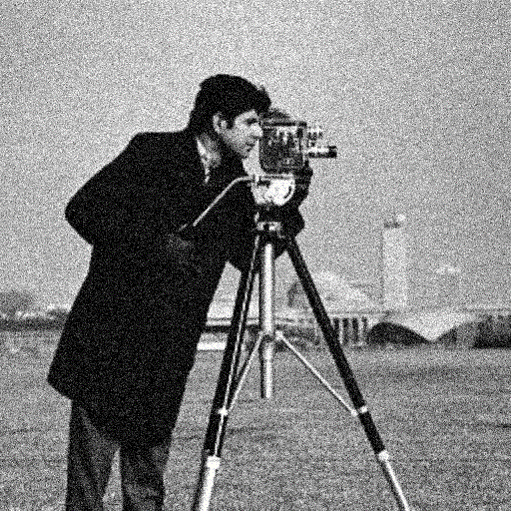

In [56]:
#Selection d'une image aléatoire
image_to_test = random.choice(os.listdir(image_to_test_dir))
# image_to_test = os.path.join(image_to_test_dir, image_to_test)
image_to_test = r'G:\DATASETS\DATASETS_CAPTIONNING\perso\cameraBruit.png'
Image.open(image_to_test)


## Classification de l'image

On predit la classe de l'image grace à notre modèle de classification

In [57]:
preds = binary_classifier.predict(image_to_test, image_h_classification, image_w_classification)
preds = np.argmax(preds, axis = - 1)
isPhoto = True
print(class_names[preds[0]])
if class_names[preds[0]] != 'Photo':
    print('ce n\'est pas une photo !')
    isPhoto = False

Painting
ce n'est pas une photo !


### Debruitage de l'image

Si l'image est une photo, on procède au débruitage.

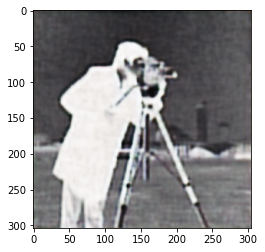

In [58]:
isPhoto = True
if isPhoto :
    clean_img = denoiser.predict(image_to_test, image_h, image_w)
    cv2.imwrite('./tmp/tmp.png', (clean_img[0] * 255).astype(np.uint8))
    clean_img = 1.0 - clean_img[0]
    plt.imshow(clean_img)
    plt.show()

## Captioning

Enfin on génère le captioning grâce aux modèle que l'on vient d'entrainer.

Prediction Caption: a man is holding a bicycle <end>


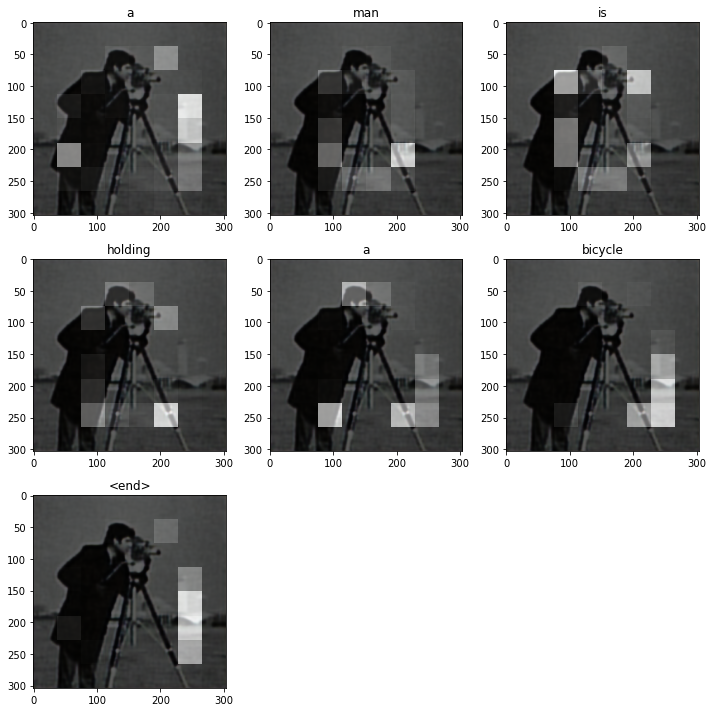

In [61]:
if isPhoto :
    image = './tmp/tmp.png'
    # image = image_to_test
    result, attention_plot = evaluate(image)
    print ('Prediction Caption:', ' '.join(result))
    plot_attention(image, result, attention_plot)